In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
median_col = 0
min_col = -2
max_col = -1

In [6]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [7]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [8]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [9]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [10]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_and_1 = torch.stack(  ( feature, torch.ones_like(feature) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_and_1, param_col)
    param_pred = torch.matmul(feature_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}, corr.={corr:.3g}')
    
    feature_np = depytorch(feature)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_np, param_np, color='blue')
    ax.plot(feature_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel(f'{param_name}')

In [11]:
plt.rcParams.update({'font.size': 20})

In [12]:
num_beta = 101
min_beta = 1e-10
max_beta = 1.0
num_threshold = 3
min_threshold = 0.0
max_threshold = 2.4
threshold = torch.tensor(data=[0.0, 1.0, 1.5], dtype=float_type, device=device)
blue_thresh = 0
green_thresh = 1
red_thresh = 2
base_color_amplitude = 1.0
red_cval = [base_color_amplitude, 0.0, 0.0]
green_cval = [0.0, base_color_amplitude, 0.0]
blue_cval = [0.0, 0.0, base_color_amplitude]
# data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_3'
param_string = f'pseudolikelihood_{data_string}_lr_0.01_updates_80000_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_length_120000'
test_beta_min = min_beta
test_beta_max = max_beta
num_test_beta = num_beta
fc_corr_beta_test_file = os.path.join(file_dir, f'fc_corr_{param_string}.pt')
fc_corr_beta_test = torch.load(fc_corr_beta_test_file, weights_only=False)
print( fc_corr_beta_test.size() )
test_beta = torch.linspace(start=test_beta_min, end=test_beta_max, steps=num_test_beta, dtype=fc_corr_beta_test.dtype, device=fc_corr_beta_test.device)

torch.Size([101, 3])


In [13]:
num_beta = 101
min_beta = 1e-10
max_beta = 0.05
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
min_updates = 0
max_updates = 40000
update_increment = 1000
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
orange_thresh = get_closest_match(values=threshold, target=1.5)
# red_thresh = get_closest_match(values=threshold, target=2.4)
red_thresh = get_closest_match(values=threshold, target=1.6)
base_color_amplitude = 1.0
red_cval = [base_color_amplitude, 0.0, 0.0]
orange_cval = [base_color_amplitude, base_color_amplitude*0.5, 0.0]
green_cval = [0.0, base_color_amplitude, 0.0]
blue_cval = [0.0, 0.0, base_color_amplitude]
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8'
param_string_final = f'{param_string}_param_updates_{max_updates}_test_length_120000'

In [13]:
ising_model_file = os.path.join(other_file_dir, f'ising_model_{param_string}.pt')
model = torch.load(ising_model_file, weights_only=False)
print( 'h size', model.h.size() )
print( 'J size', model.J.size() )

h size torch.Size([101, 31, 360])
J size torch.Size([101, 31, 360, 360])


In [111]:
test_beta_min = 1e-09
test_beta_max = 0.025
num_test_beta = num_beta
fc_corr_beta_test_file = os.path.join(other_file_dir, f'fc_corr_{param_string}_test_beta_min_{test_beta_min:.3g}_max_{test_beta_max:.3g}_sim_steps_120000.pt')
fc_corr_beta_test = torch.load(fc_corr_beta_test_file, weights_only=False)
print( fc_corr_beta_test.size() )
test_beta = torch.linspace(start=test_beta_min, end=test_beta_max, steps=num_test_beta, dtype=fc_corr_beta_test.dtype, device=fc_corr_beta_test.device)

torch.Size([101, 31])


In [112]:
fc_corr_summary_file = os.path.join(file_dir, f'summary_fc_corr_all_ising_model_{param_string}_param_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}.pt')
fc_corr_summary = torch.load(fc_corr_summary_file, weights_only=False)
print( fc_corr_summary.size() )
num_updates = (max_updates - min_updates)//update_increment + 1
update_count = torch.linspace(start=min_updates, end=max_updates, steps=num_updates, dtype=fc_corr_summary.dtype, device=fc_corr_summary.device)

torch.Size([41, 31, 5])


In [113]:
fc_corr_final_file = os.path.join(file_dir, f'fc_corr_ising_model_{param_string_final}.pt')
fc_corr_final = torch.load(fc_corr_final_file, weights_only=False)
print( fc_corr_final.size() )

torch.Size([101, 31])


In [119]:
fc_corr_homogenized_h_file = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000h_mean_area_test_length_120000.pt')
fc_corr_homogenized_h = torch.load(fc_corr_homogenized_h_file, weights_only=False)
print( fc_corr_homogenized_h.size() )

torch.Size([101, 31])


In [130]:
fc_corr_v_as_is_file = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_as_is_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt')
fc_corr_v_as_is = torch.load(fc_corr_v_as_is_file, weights_only=False)
print( fc_corr_v_as_is.size() )

torch.Size([101, 31])


In [114]:
selected_indices = [blue_thresh, green_thresh, red_thresh]
selected_colors = [blue_cval, green_cval, red_cval]

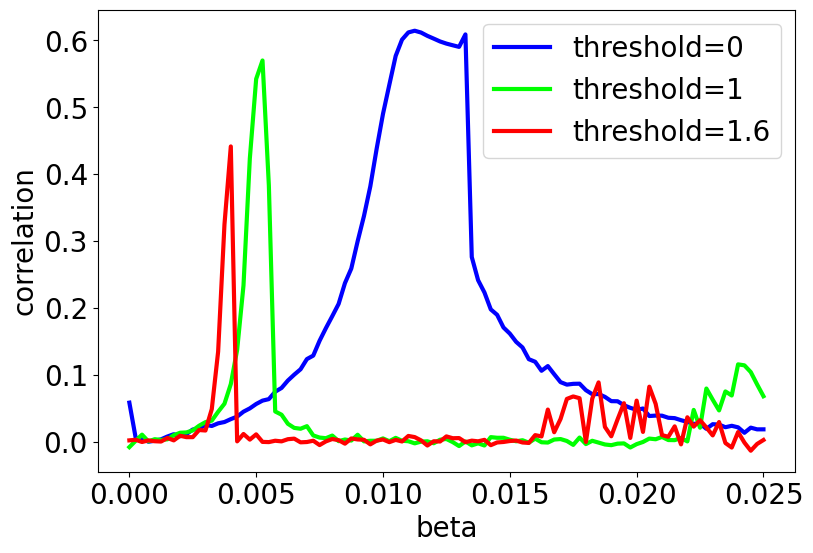

In [115]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
test_beta_np = depytorch(test_beta)
fc_corr_beta_test_np = depytorch(fc_corr_beta_test)
line_width = 3.0
max_beta_index = num_beta
# max_beta_index = torch.argmin( torch.abs(test_beta - 0.02) )
for threshold_index, cval in zip(selected_indices,selected_colors):
    axs.plot( test_beta_np[:max_beta_index], fc_corr_beta_test_np[:max_beta_index,threshold_index], color=cval, linewidth=line_width, label=f'threshold={threshold[threshold_index]:.3g}' )
axs.set_xlabel('beta')
axs.set_ylabel('correlation')
axs.legend()
plt.show()

In [116]:
fc_corr_is_nan = torch.isnan(fc_corr_beta_test)
fc_corr_is_inf = torch.isinf(fc_corr_beta_test)
fc_corr_is_bad = torch.logical_or(fc_corr_is_nan, fc_corr_is_inf)
fc_corr_beta_test[fc_corr_is_bad] = -float('inf')
max_fc_corr, max_fc_corr_index = torch.max(fc_corr_beta_test[1:,:], dim=0)
max_fc_corr_index = max_fc_corr_index+1
max_fc_corr_beta = test_beta[max_fc_corr_index]
for threshold_index in selected_indices:
    print(f'For threshold {threshold[threshold_index]:.3g}, maximum FC correlation {max_fc_corr[threshold_index]:.3g} occurs at beta {max_fc_corr_beta[threshold_index]:.3g}.')

For threshold 0, maximum FC correlation 0.614 occurs at beta 0.0113.
For threshold 1, maximum FC correlation 0.57 occurs at beta 0.00525.
For threshold 1.6, maximum FC correlation 0.441 occurs at beta 0.004.


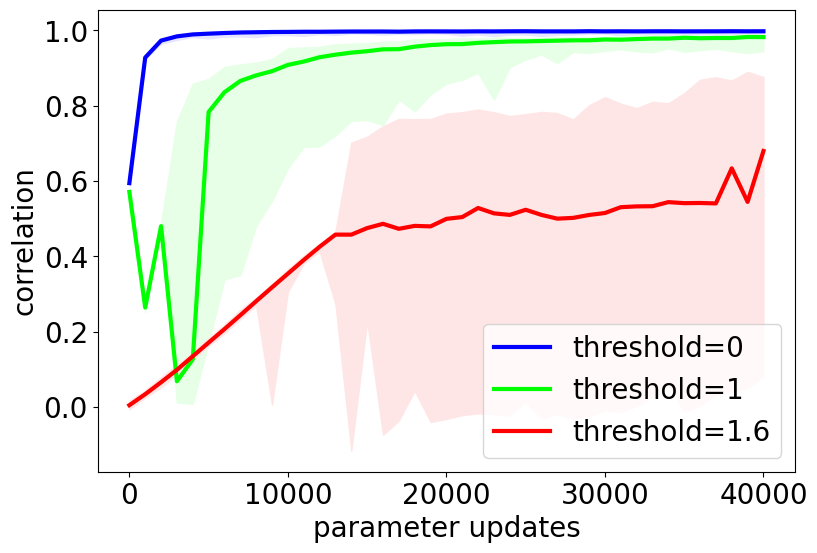

In [117]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
update_count_np = depytorch(update_count)
fc_corr_min_np = depytorch(fc_corr_summary[:,:,min_col])
fc_corr_median_np = depytorch(fc_corr_summary[:,:,median_col])
fc_corr_max_np = depytorch(fc_corr_summary[:,:,max_col])
line_width = 3.0
for threshold_index, cval in zip(selected_indices,selected_colors):
    fc_corr_min_for_thresh = fc_corr_min_np[:,threshold_index]
    fc_corr_max_for_thresh = fc_corr_max_np[:,threshold_index]
    selected_threshold = threshold[threshold_index]
    if (fc_corr_max_for_thresh - fc_corr_min_for_thresh).max() > 0.001:
        axs.fill_between( update_count_np, fc_corr_min_for_thresh, fc_corr_max_for_thresh, color=[0.9+0.1*c for c in cval])# , label=f'thresh.={selected_threshold:.3g} range'
        # axs.plot( update_count_np, fc_corr_min_for_thresh, color=cval, linestyle='--', linewidth=line_width )
        # axs.plot( update_count_np, fc_corr_max_for_thresh, color=cval, linestyle='--', linewidth=line_width )
    axs.plot( update_count_np, fc_corr_median_np[:,threshold_index], color=cval, linewidth=line_width, label=f'threshold={selected_threshold:.3g}' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend( loc='lower right' )# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('parameter updates')
axs.set_ylabel('correlation')
plt.show()

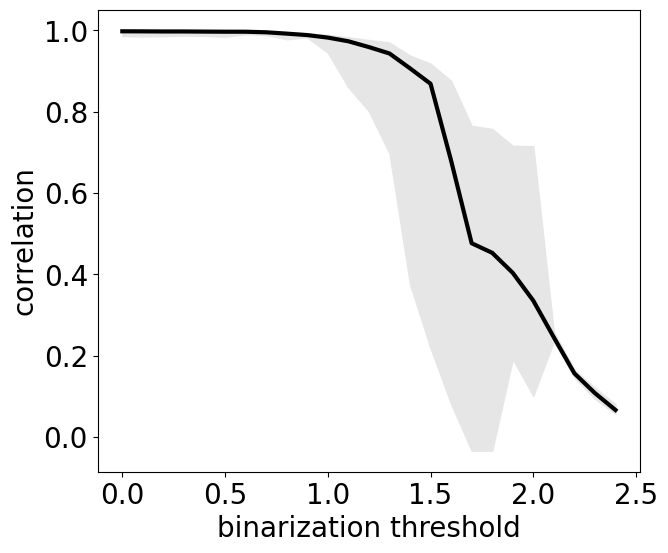

In [122]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(7, 6) )
end_thresh = get_closest_match(values=threshold, target=2.5)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

fc_corr_min_final = depytorch(fc_corr_summary[-1,:end_thresh,min_col])
fc_corr_max_final = depytorch(fc_corr_summary[-1,:end_thresh,max_col])
fc_corr_median_final = depytorch(fc_corr_summary[-1,:end_thresh,median_col])

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, fc_corr_min_final, fc_corr_max_final, color=[0.9+0.1*c for c in cval], label=f'range' )
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_median_final, color=cval, linewidth=line_width, label=f'median' )

# axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

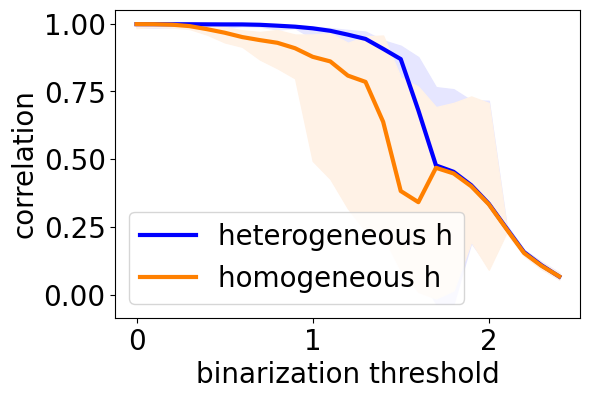

In [126]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.5)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

fc_corr_min_final = depytorch(fc_corr_summary[-1,:end_thresh,min_col])
fc_corr_max_final = depytorch(fc_corr_summary[-1,:end_thresh,max_col])
fc_corr_median_final = depytorch(fc_corr_summary[-1,:end_thresh,median_col])

cval = blue_cval
axs.fill_between( threshold_np, fc_corr_min_final, fc_corr_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_median_final, color=cval, linewidth=line_width, label=f'heterogeneous h' )

fc_corr_hom_h_min_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].min(dim=0).values )
fc_corr_hom_h_max_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].max(dim=0).values )
fc_corr_hom_h_median_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].median(dim=0).values )

cval = orange_cval
axs.fill_between( threshold_np, fc_corr_hom_h_min_final, fc_corr_hom_h_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_hom_h_median_final, color=cval, linewidth=line_width, label=f'homogeneous h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

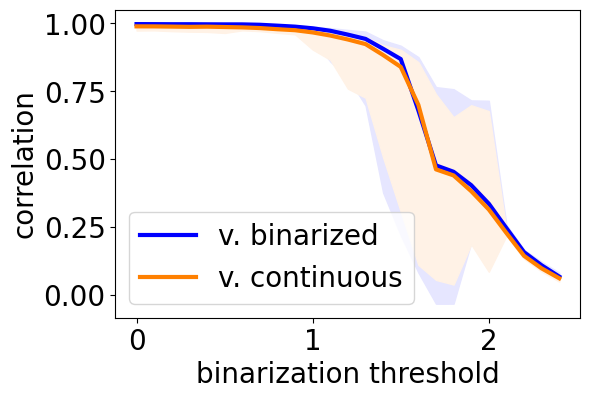

In [135]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.5)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

fc_corr_min_final = depytorch(fc_corr_summary[-1,:end_thresh,min_col])
fc_corr_max_final = depytorch(fc_corr_summary[-1,:end_thresh,max_col])
fc_corr_median_final = depytorch(fc_corr_summary[-1,:end_thresh,median_col])

cval = blue_cval
axs.fill_between( threshold_np, fc_corr_min_final, fc_corr_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_median_final, color=cval, linewidth=line_width, label=f'v. binarized' )

fc_corr_v_as_is_min_final = depytorch( fc_corr_v_as_is[:,:end_thresh].min(dim=0).values )
fc_corr_v_as_is_max_final = depytorch( fc_corr_v_as_is[:,:end_thresh].max(dim=0).values )
fc_corr_v_as_is_median_final = depytorch( fc_corr_v_as_is[:,:end_thresh].median(dim=0).values )

cval = orange_cval
axs.fill_between( threshold_np, fc_corr_v_as_is_min_final, fc_corr_v_as_is_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_v_as_is_median_final, color=cval, linewidth=line_width, label=f'v. continuous' )

axs.legend(loc='lower left')
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

In [127]:
mean_state_all_as_is = torch.load( os.path.join(file_dir, 'mean_state_all_as_is.pt'), weights_only=False )
print( mean_state_all_as_is.size() )
mean_state_product_all_as_is = torch.load( os.path.join(file_dir, 'mean_state_product_all_as_is.pt'), weights_only=False )
print( mean_state_product_all_as_is.size() )

torch.Size([4, 837, 360])
torch.Size([4, 837, 360, 360])


In [128]:
mean_state_group_as_is = mean_state_all_as_is[:,training_subject_start:training_subject_end,:].mean( dim=(0,1), keepdim=True )
print( mean_state_group_as_is.size() )
mean_state_product_group_as_is = mean_state_product_all_as_is[:,training_subject_start:training_subject_end,:,:].mean( dim=(0,1), keepdim=True )
print( mean_state_product_group_as_is.size() )

torch.Size([1, 1, 360])
torch.Size([1, 1, 360, 360])


In [129]:
torch.save( obj=mean_state_group_as_is, f=os.path.join(file_dir, 'mean_state_group_as_is.pt') )
torch.save( obj=mean_state_product_group_as_is, f=os.path.join(file_dir, 'mean_state_product_group_as_is.pt') )

In [14]:
fc_corr_group_vs_individual_file_0 = os.path.join(file_dir, f'fc_corr_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_test_length_120000.pt')
# fc_corr_group_vs_individual_file_0 = os.path.join(file_dir, f'fc_corr_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_20000_reset_test_length_120000.pt')
fc_corr_group_vs_individual_0 = torch.load(fc_corr_group_vs_individual_file_0, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_group_vs_individual_0.size() )
print( fc_corr_group_vs_individual_0.min(), fc_corr_group_vs_individual_0.median(), fc_corr_group_vs_individual_0.max() )

torch.Size([5, 837])
tensor(0.5288, device='cuda:0') tensor(0.7827, device='cuda:0') tensor(0.8686, device='cuda:0')


In [15]:
fc_corr_group_vs_individual_file_1 = os.path.join(file_dir, f'fc_corr_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_40000_test_length_120000.pt')
fc_corr_group_vs_individual_1 = torch.load(fc_corr_group_vs_individual_file_1, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_group_vs_individual_1.size() )
print( fc_corr_group_vs_individual_1.min(), fc_corr_group_vs_individual_1.median(), fc_corr_group_vs_individual_1.max() )

torch.Size([5, 837])
tensor(0.3653, device='cuda:0') tensor(0.7553, device='cuda:0') tensor(0.8688, device='cuda:0')


In [16]:
fc_corr_individual_file_0 = os.path.join(file_dir, f'fc_corr_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_test_length_120000.pt')
fc_corr_individual_0 = torch.load(fc_corr_individual_file_0, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0.size() )
print( fc_corr_individual_0.min(), fc_corr_individual_0.median(), fc_corr_individual_0.max() )

torch.Size([5, 837])
tensor(0.8957, device='cuda:0') tensor(0.9918, device='cuda:0') tensor(0.9978, device='cuda:0')


In [17]:
fc_corr_individual_file_0_no_h = os.path.join(file_dir, f'fc_corr_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_no_h_test_length_120000.pt')
fc_corr_individual_0_no_h = torch.load(fc_corr_individual_file_0_no_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0_no_h.size() )
print( fc_corr_individual_0_no_h.min(), fc_corr_individual_0_no_h.median(), fc_corr_individual_0_no_h.max() )

torch.Size([5, 837])
tensor(0.8872, device='cuda:0') tensor(0.9918, device='cuda:0') tensor(0.9976, device='cuda:0')


In [18]:
fc_corr_individual_file_1 = os.path.join(file_dir, f'fc_corr_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_test_length_120000.pt')
fc_corr_individual_1 = torch.load(fc_corr_individual_file_1, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1.size() )
print( fc_corr_individual_1.min(), fc_corr_individual_1.median(), fc_corr_individual_1.max() )

torch.Size([5, 837])
tensor(0.3294, device='cuda:0') tensor(0.9757, device='cuda:0') tensor(0.9929, device='cuda:0')


In [19]:
fc_corr_individual_file_1_no_h = os.path.join(file_dir, f'fc_corr_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_no_h_test_length_120000.pt')
fc_corr_individual_1_no_h = torch.load(fc_corr_individual_file_1_no_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1_no_h.size() )
print( fc_corr_individual_1_no_h.min(), fc_corr_individual_1_no_h.median(), fc_corr_individual_1_no_h.max() )

torch.Size([5, 837])
tensor(0.4968, device='cuda:0') tensor(0.9235, device='cuda:0') tensor(0.9858, device='cuda:0')


In [20]:
fc_corr_individual_file_0_group_mean_h = os.path.join(file_dir, f'fc_corr_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000h_mean_group_test_length_120000.pt')
fc_corr_individual_0_group_mean_h = torch.load(fc_corr_individual_file_0_group_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0_group_mean_h.size() )
print( fc_corr_individual_0_group_mean_h.min(), fc_corr_individual_0_group_mean_h.median(), fc_corr_individual_0_group_mean_h.max() )

torch.Size([5, 837])
tensor(0.8950, device='cuda:0') tensor(0.9918, device='cuda:0') tensor(0.9980, device='cuda:0')


In [21]:
fc_corr_individual_file_0_area_mean_h = os.path.join(file_dir, f'fc_corr_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000h_mean_area_test_length_120000.pt')
fc_corr_individual_0_area_mean_h = torch.load(fc_corr_individual_file_0_area_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0_area_mean_h.size() )
print( fc_corr_individual_0_area_mean_h.min(), fc_corr_individual_0_area_mean_h.median(), fc_corr_individual_0_area_mean_h.max() )

torch.Size([5, 837])
tensor(0.9004, device='cuda:0') tensor(0.9919, device='cuda:0') tensor(0.9978, device='cuda:0')


In [22]:
fc_corr_individual_file_1_group_mean_h = os.path.join(file_dir, f'fc_corr_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000h_mean_group_test_length_120000.pt')
fc_corr_individual_1_group_mean_h = torch.load(fc_corr_individual_file_1_group_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1_group_mean_h.size() )
print( fc_corr_individual_1_group_mean_h.min(), fc_corr_individual_1_group_mean_h.median(), fc_corr_individual_1_group_mean_h.max() )

torch.Size([5, 837])
tensor(0.0150, device='cuda:0') tensor(0.8551, device='cuda:0') tensor(0.9710, device='cuda:0')


In [23]:
fc_corr_individual_file_1_area_mean_h = os.path.join(file_dir, f'fc_corr_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000h_mean_area_test_length_120000.pt')
fc_corr_individual_1_area_mean_h = torch.load(fc_corr_individual_file_1_area_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1_area_mean_h.size() )
print( fc_corr_individual_1_area_mean_h.min(), fc_corr_individual_1_area_mean_h.median(), fc_corr_individual_1_area_mean_h.max() )

torch.Size([5, 837])
tensor(0.0868, device='cuda:0') tensor(0.7649, device='cuda:0') tensor(0.9703, device='cuda:0')


In [24]:
fc_corr_individual_file_0 = os.path.join(file_dir, f'fc_corr_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_test_length_120000.pt')
fc_corr_individual_0 = torch.load(fc_corr_individual_file_0, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0.size() )
print( fc_corr_individual_0.min(), fc_corr_individual_0.median(), fc_corr_individual_0.max() )

torch.Size([5, 837])
tensor(0.8623, device='cuda:0') tensor(0.9927, device='cuda:0') tensor(0.9978, device='cuda:0')


In [25]:
fc_corr_individual_file_1 = os.path.join(file_dir, f'fc_corr_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_test_length_120000.pt')
fc_corr_individual_1 = torch.load(fc_corr_individual_file_1, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1.size() )
print( fc_corr_individual_1.min(), fc_corr_individual_1.median(), fc_corr_individual_1.max() )

torch.Size([5, 837])
tensor(0.3372, device='cuda:0') tensor(0.9791, device='cuda:0') tensor(0.9933, device='cuda:0')


In [57]:
fc_corr_individual_file_0 = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_0_reps_5_subj_837_individual_updates_40000_test_length_120000.pt')
fc_corr_individual_0 = torch.load(fc_corr_individual_file_0, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0.size() )
print( fc_corr_individual_0.min(), fc_corr_individual_0.median(), fc_corr_individual_0.max() )

torch.Size([5, 837])
tensor(0.8116, device='cuda:0') tensor(0.9937, device='cuda:0') tensor(0.9991, device='cuda:0')


In [58]:
fc_corr_individual_file_1 = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_1_reps_5_subj_837_individual_updates_40000_test_length_120000.pt')
fc_corr_individual_1 = torch.load(fc_corr_individual_file_1, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1.size() )
print( fc_corr_individual_1.min(), fc_corr_individual_1.median(), fc_corr_individual_1.max() )

torch.Size([5, 837])
tensor(0.1894, device='cuda:0') tensor(0.9800, device='cuda:0') tensor(0.9929, device='cuda:0')


In [59]:
is_bad = fc_corr_individual_1 < 0.9
print( torch.count_nonzero(is_bad) )
print( fc_corr_individual_1[is_bad] )

tensor(39, device='cuda:0')
tensor([0.8846, 0.8779, 0.4209, 0.4228, 0.1894, 0.6004, 0.8665, 0.8788, 0.8865,
        0.8833, 0.8361, 0.8850, 0.4713, 0.8393, 0.8177, 0.8613, 0.8635, 0.8612,
        0.8830, 0.8194, 0.3892, 0.8676, 0.8620, 0.8654, 0.8981, 0.8931, 0.8993,
        0.8979, 0.8945, 0.8307, 0.7727, 0.8930, 0.8540, 0.7657, 0.8920, 0.8515,
        0.8985, 0.7834, 0.8429], device='cuda:0')


In [60]:
fc_corr_individual_1_worst_rep, fc_corr_individual_1_worst_rep_index = torch.min(fc_corr_individual_1, dim=0)
print( fc_corr_individual_1_worst_rep.size() )
print( fc_corr_individual_1_worst_rep.min(), fc_corr_individual_1_worst_rep.median(), fc_corr_individual_1_worst_rep.max() )

torch.Size([837])
tensor(0.1894, device='cuda:0') tensor(0.9726, device='cuda:0') tensor(0.9878, device='cuda:0')


In [61]:
worst_is_bad = fc_corr_individual_1_worst_rep < 0.9
print( torch.count_nonzero(worst_is_bad) )
print( fc_corr_individual_1[:,worst_is_bad] )

tensor(33, device='cuda:0')
tensor([[0.9723, 0.8846, 0.9867, 0.9791, 0.9769, 0.9917, 0.9870, 0.8779, 0.9832,
         0.9879, 0.9761, 0.9823, 0.9293, 0.9660, 0.9815, 0.9091, 0.9829, 0.9839,
         0.9762, 0.9694, 0.9048, 0.9027, 0.9779, 0.9733, 0.9520, 0.9480, 0.9815,
         0.4209, 0.4228, 0.1894, 0.6004, 0.9839, 0.8665],
        [0.8788, 0.9721, 0.9624, 0.9772, 0.9824, 0.9893, 0.9524, 0.9783, 0.9275,
         0.9832, 0.9864, 0.9826, 0.9811, 0.8865, 0.8833, 0.9655, 0.8361, 0.8850,
         0.4713, 0.9822, 0.8393, 0.9735, 0.8177, 0.9631, 0.9715, 0.9689, 0.9879,
         0.9814, 0.9850, 0.9777, 0.9873, 0.9833, 0.9818],
        [0.8613, 0.9832, 0.8635, 0.9816, 0.8612, 0.9808, 0.9532, 0.9770, 0.9561,
         0.8830, 0.8194, 0.9861, 0.9685, 0.3892, 0.9420, 0.9647, 0.9812, 0.9645,
         0.9800, 0.9778, 0.8676, 0.9725, 0.9827, 0.9768, 0.9849, 0.9101, 0.9807,
         0.9843, 0.9836, 0.9689, 0.9864, 0.9656, 0.9693],
        [0.9428, 0.9691, 0.9685, 0.8620, 0.9843, 0.9907, 0.8654, 0.98

In [62]:
fc_corr_individual_1_best_rep, fc_corr_individual_1_best_rep_index = torch.max(fc_corr_individual_1, dim=0)
print( fc_corr_individual_1_best_rep.size() )
print( fc_corr_individual_1_best_rep.min(), fc_corr_individual_1_best_rep.median(), fc_corr_individual_1_best_rep.max() )

torch.Size([837])
tensor(0.9660, device='cuda:0') tensor(0.9837, device='cuda:0') tensor(0.9929, device='cuda:0')


In [63]:
print( torch.nonzero(worst_is_bad).flatten().tolist() )

[18, 29, 30, 131, 145, 149, 155, 173, 175, 205, 233, 235, 258, 261, 264, 279, 300, 320, 349, 451, 456, 508, 529, 542, 544, 558, 628, 638, 662, 677, 702, 796, 801]


In [64]:
worst_is_bad_v1 = worst_is_bad

In [32]:
fc_corr_individual_file_0_group_mean_h = os.path.join(file_dir, f'fc_corr_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_h_mean_group_test_length_120000.pt')
fc_corr_individual_0_group_mean_h = torch.load(fc_corr_individual_file_0_group_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0_group_mean_h.size() )
print( fc_corr_individual_0_group_mean_h.min(), fc_corr_individual_0_group_mean_h.median(), fc_corr_individual_0_group_mean_h.max() )

torch.Size([5, 837])
tensor(0.8647, device='cuda:0') tensor(0.9927, device='cuda:0') tensor(0.9976, device='cuda:0')


In [65]:
fc_corr_individual_file_0_group_mean_h = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_0_reps_5_subj_837_individual_updates_40000_h_mean_group_test_length_120000.pt')
fc_corr_individual_0_group_mean_h = torch.load(fc_corr_individual_file_0_group_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_0_group_mean_h.size() )
print( fc_corr_individual_0_group_mean_h.min(), fc_corr_individual_0_group_mean_h.median(), fc_corr_individual_0_group_mean_h.max() )

torch.Size([5, 837])
tensor(0.8076, device='cuda:0') tensor(0.9936, device='cuda:0') tensor(0.9992, device='cuda:0')


In [33]:
fc_corr_individual_file_1_group_mean_h = os.path.join(file_dir, f'fc_corr_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_h_mean_group_test_length_120000.pt')
fc_corr_individual_1_group_mean_h = torch.load(fc_corr_individual_file_1_group_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1_group_mean_h.size() )
print( fc_corr_individual_1_group_mean_h.min(), fc_corr_individual_1_group_mean_h.median(), fc_corr_individual_1_group_mean_h.max() )

torch.Size([5, 837])
tensor(0.0313, device='cuda:0') tensor(0.8736, device='cuda:0') tensor(0.9696, device='cuda:0')


In [66]:
fc_corr_individual_file_1_group_mean_h = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_1_reps_5_subj_837_individual_updates_40000_h_mean_group_test_length_120000.pt')
fc_corr_individual_1_group_mean_h = torch.load(fc_corr_individual_file_1_group_mean_h, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1_group_mean_h.size() )
print( fc_corr_individual_1_group_mean_h.min(), fc_corr_individual_1_group_mean_h.median(), fc_corr_individual_1_group_mean_h.max() )

torch.Size([5, 837])
tensor(0.0500, device='cuda:0') tensor(0.9013, device='cuda:0') tensor(0.9740, device='cuda:0')


In [34]:
fc_corr_individual_file_1_v2 = os.path.join(file_dir, f'fc_corr_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_test_length_120000_v2.pt')
fc_corr_individual_1_v2 = torch.load(fc_corr_individual_file_1_v2, weights_only=False)# [:,training_subject_start:training_subject_end]
print( fc_corr_individual_1_v2.size() )
print( fc_corr_individual_1_v2.min(), fc_corr_individual_1_v2.median(), fc_corr_individual_1_v2.max() )

torch.Size([5, 837])
tensor(0.3402, device='cuda:0') tensor(0.9790, device='cuda:0') tensor(0.9939, device='cuda:0')


In [35]:
is_bad = fc_corr_individual_1_v2 < 0.9
print( torch.count_nonzero(is_bad) )
print( fc_corr_individual_1_v2[is_bad] )

tensor(34, device='cuda:0')
tensor([0.8660, 0.8904, 0.8795, 0.8284, 0.8932, 0.8519, 0.8901, 0.8824, 0.4424,
        0.5259, 0.8891, 0.7882, 0.4577, 0.8798, 0.8365, 0.7934, 0.8268, 0.8731,
        0.8749, 0.8267, 0.8682, 0.7988, 0.8647, 0.8961, 0.3402, 0.8394, 0.8989,
        0.8976, 0.8810, 0.8910, 0.8086, 0.7948, 0.8903, 0.8750],
       device='cuda:0')


In [36]:
num_bad_reps = torch.count_nonzero(is_bad, dim=0)
print( num_bad_reps.max().item() )

2


In [37]:
fc_corr_individual_1_worst_rep, fc_corr_individual_1_worst_rep_index = torch.min(fc_corr_individual_1_v2, dim=0)
print( fc_corr_individual_1_worst_rep.size() )
print( fc_corr_individual_1_worst_rep.min(), fc_corr_individual_1_worst_rep.median(), fc_corr_individual_1_worst_rep.max() )

torch.Size([837])
tensor(0.3402, device='cuda:0') tensor(0.9714, device='cuda:0') tensor(0.9863, device='cuda:0')


In [38]:
worst_is_bad = fc_corr_individual_1_worst_rep < 0.9
print( torch.count_nonzero(worst_is_bad) )
print( fc_corr_individual_1_v2[:,worst_is_bad] )

tensor(30, device='cuda:0')
tensor([[0.9647, 0.8660, 0.9870, 0.9784, 0.9731, 0.8904, 0.9864, 0.9769, 0.9834,
         0.9698, 0.9521, 0.9404, 0.9788, 0.9850, 0.8795, 0.8284, 0.9822, 0.9537,
         0.9554, 0.9891, 0.9863, 0.9710, 0.9902, 0.9643, 0.9770, 0.8932, 0.8519,
         0.9592, 0.9806, 0.8901],
        [0.9430, 0.9806, 0.8824, 0.9804, 0.9739, 0.9671, 0.9851, 0.9854, 0.9355,
         0.9646, 0.9390, 0.4424, 0.9634, 0.9387, 0.9831, 0.9749, 0.9815, 0.5259,
         0.8891, 0.7882, 0.9767, 0.9621, 0.4577, 0.9765, 0.8798, 0.9638, 0.9847,
         0.8365, 0.9823, 0.9708],
        [0.7934, 0.8268, 0.9621, 0.8731, 0.9702, 0.9832, 0.9871, 0.9768, 0.9837,
         0.8749, 0.9807, 0.9630, 0.9733, 0.8267, 0.9653, 0.9756, 0.9783, 0.9851,
         0.9591, 0.9880, 0.8682, 0.9035, 0.9841, 0.9719, 0.9869, 0.9806, 0.9448,
         0.9811, 0.9324, 0.9444],
        [0.9400, 0.9756, 0.9782, 0.9353, 0.7988, 0.9785, 0.8647, 0.8961, 0.9861,
         0.9660, 0.9764, 0.3402, 0.8394, 0.9821, 0.9849, 0.9

In [39]:
fc_corr_individual_1_best_rep, fc_corr_individual_1_best_rep_index = torch.max(fc_corr_individual_1_v2, dim=0)
print( fc_corr_individual_1_best_rep.size() )
print( fc_corr_individual_1_best_rep.min(), fc_corr_individual_1_best_rep.median(), fc_corr_individual_1_best_rep.max() )

torch.Size([837])
tensor(0.9430, device='cuda:0') tensor(0.9830, device='cuda:0') tensor(0.9939, device='cuda:0')


In [40]:
print( torch.nonzero(worst_is_bad).flatten().tolist() )

[18, 29, 35, 44, 86, 131, 132, 174, 175, 198, 227, 234, 235, 258, 346, 350, 359, 375, 387, 393, 548, 558, 580, 586, 609, 636, 691, 777, 795, 801]


In [41]:
worst_is_bad_v2 = worst_is_bad

In [42]:
worst_is_bad_both = torch.logical_and(worst_is_bad_v1, worst_is_bad_v2)
print( torch.nonzero(worst_is_bad_both).flatten().tolist() )

[29, 175, 227, 234, 235, 350, 375, 558, 609, 691, 777, 795, 801]


In [43]:
print( torch.count_nonzero(worst_is_bad) )
print( fc_corr_individual_1[:,worst_is_bad_both] )

tensor(30, device='cuda:0')
tensor([[0.8475, 0.9739, 0.9578, 0.9033, 0.9867, 0.6116, 0.9635, 0.9674, 0.9826,
         0.8685, 0.9691, 0.9724, 0.8939],
        [0.9755, 0.9449, 0.8957, 0.3372, 0.8495, 0.9829, 0.8890, 0.9723, 0.8698,
         0.9815, 0.6880, 0.9807, 0.9576],
        [0.8422, 0.9815, 0.9855, 0.9809, 0.9815, 0.9781, 0.9873, 0.8679, 0.9862,
         0.9365, 0.9663, 0.9258, 0.9465],
        [0.9738, 0.9808, 0.9776, 0.6838, 0.9277, 0.9701, 0.9818, 0.9311, 0.9573,
         0.9674, 0.9724, 0.8954, 0.9544],
        [0.9665, 0.8685, 0.6791, 0.9503, 0.9815, 0.9677, 0.9826, 0.9690, 0.9824,
         0.8590, 0.9724, 0.9691, 0.9757]], device='cuda:0')


In [44]:
print( torch.count_nonzero(worst_is_bad) )
print( fc_corr_individual_1_v2[:,worst_is_bad_both] )

tensor(30, device='cuda:0')
tensor([[0.8660, 0.9834, 0.9521, 0.9404, 0.9788, 0.8284, 0.9537, 0.9710, 0.9770,
         0.8519, 0.9592, 0.9806, 0.8901],
        [0.9806, 0.9355, 0.9390, 0.4424, 0.9634, 0.9749, 0.5259, 0.9621, 0.8798,
         0.9847, 0.8365, 0.9823, 0.9708],
        [0.8268, 0.9837, 0.9807, 0.9630, 0.9733, 0.9756, 0.9851, 0.9035, 0.9869,
         0.9448, 0.9811, 0.9324, 0.9444],
        [0.9756, 0.9861, 0.9764, 0.3402, 0.8394, 0.9840, 0.9726, 0.8976, 0.9455,
         0.9710, 0.9712, 0.8810, 0.9399],
        [0.9547, 0.8086, 0.7948, 0.9654, 0.9801, 0.9546, 0.9823, 0.9799, 0.9800,
         0.8750, 0.9749, 0.9731, 0.9343]], device='cuda:0')


tensor(0.6406, device='cuda:0')
test sim 2=0.641test sim 1+0.35, R^2=0.411, corr.=0.641


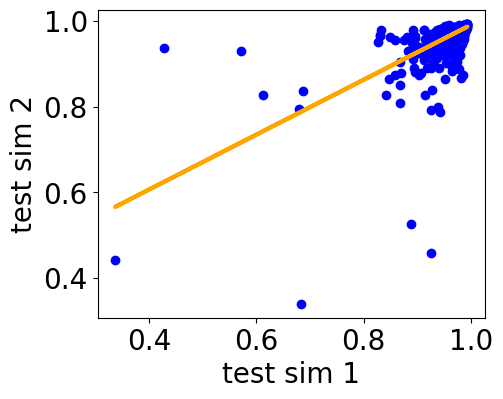

In [45]:
fc_corr_individual_1_flat = fc_corr_individual_1.flatten()
fc_corr_individual_1_v2_flat = fc_corr_individual_1_v2.flatten()
print( isingmodellight.get_pairwise_correlation(fc_corr_individual_1_flat, fc_corr_individual_1_v2_flat, epsilon=0.0) )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax, feature=fc_corr_individual_1_flat, param=fc_corr_individual_1_v2_flat, feature_name='test sim 1', param_name='test sim 2')

In [46]:
training_subject_start=0
training_subject_end = 670
fc_corr_individual_1_v2_mean = fc_corr_individual_1_v2.mean(dim=0)
print(   stats.mannwhitneyu(  depytorch(fc_corr_individual_1_v2_mean[training_subject_start:training_subject_end]), depytorch(fc_corr_individual_1_v2_mean[training_subject_end:]), alternative='greater'  )   )

MannwhitneyuResult(statistic=np.float64(49986.0), pvalue=np.float64(0.9834956898614838))


In [67]:
training_subject_start=0
training_subject_end = 670
fc_corr_individual_1_mean = fc_corr_individual_1.mean(dim=0)
print(   stats.mannwhitneyu(  depytorch(fc_corr_individual_1_mean[training_subject_start:training_subject_end]), depytorch(fc_corr_individual_1_mean[training_subject_end:]), alternative='greater'  )   )

MannwhitneyuResult(statistic=np.float64(49498.0), pvalue=np.float64(0.989460255656715))


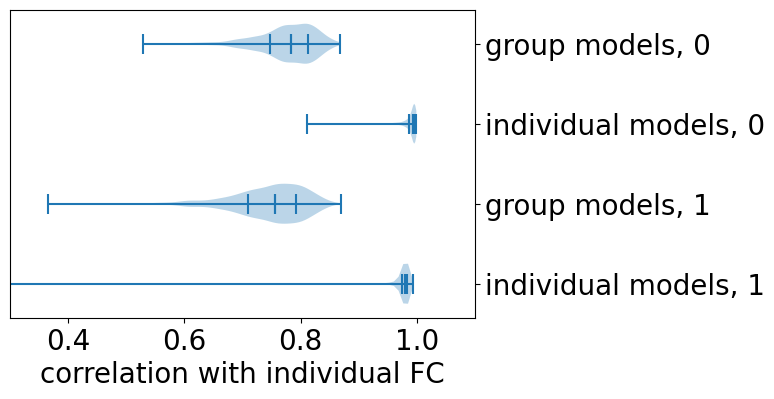

In [68]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
# 'group model v. individual data, threshold=0', 
# 'group model v. individual data, threshold=1', 
corr_labels = ['individual models, 1', 'group models, 1', 'individual models, 0', 'group models, 0']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fc.flatten() ) for fc in [fc_corr_individual_1, fc_corr_group_vs_individual_1, fc_corr_individual_0, fc_corr_group_vs_individual_0] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('correlation with individual FC')
axs.set_xlim([0.3, 1.1])
plt.show()

In [69]:
result_0 = stats.wilcoxon(  x=depytorch( fc_corr_individual_0.flatten() ), y=depytorch( fc_corr_group_vs_individual_0.flatten() ), alternative='greater'  )
print(f'FC corr. individual model v. individual data > group model v. individual data, threshold=0 p-value = {result_0.pvalue:.3g}, stat {result_0.statistic:.3g}')
result_1 = stats.wilcoxon(  x=depytorch( fc_corr_individual_1.flatten() ), y=depytorch( fc_corr_group_vs_individual_1.flatten() ), alternative='greater'  )
print(f'FC corr. individual model v. individual data > group model v. individual data, threshold=1 p-value = {result_1.pvalue:.3g}, stat {result_1.statistic:.3g}')

FC corr. individual model v. individual data > group model v. individual data, threshold=0 p-value = 0, stat 8.76e+06
FC corr. individual model v. individual data > group model v. individual data, threshold=1 p-value = 0, stat 8.75e+06


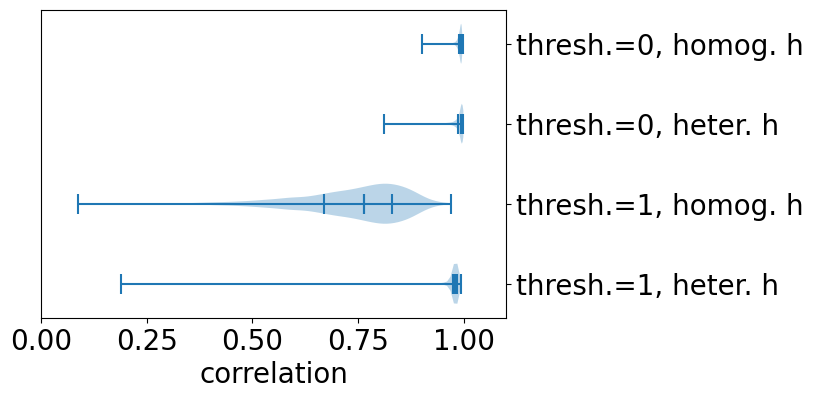

In [70]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
# 'group model v. individual data, threshold=0',
# 'group model v. individual data, threshold=1',
corr_labels = ['thresh.=1, heter. h', 'thresh.=1, homog. h', 'thresh.=0, heter. h', 'thresh.=0, homog. h']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fc.flatten() ) for fc in [fc_corr_individual_1, fc_corr_individual_1_area_mean_h, fc_corr_individual_0, fc_corr_individual_0_area_mean_h] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('correlation')
axs.set_xlim([0.0, 1.1])
# axs.set_title('effect of replacing h with mean over areas')
plt.show()

In [71]:
result_0 = stats.wilcoxon(  x=depytorch( fc_corr_individual_0.flatten() ), y=depytorch( fc_corr_individual_0_area_mean_h.flatten() ), alternative='greater'  )
print(f'FC corr. individual h > mean-over-areas h, threshold=0 p-value = {result_0.pvalue:.3g}, stat {result_0.statistic:.3g}')
result_1 = stats.wilcoxon(  x=depytorch( fc_corr_individual_1.flatten() ), y=depytorch( fc_corr_individual_1_area_mean_h.flatten() ), alternative='greater'  )
print(f'FC corr. individual h > mean-over-areas h, threshold=1 p-value = {result_1.pvalue:.3g}, stat {result_1.statistic:.3g}')

FC corr. individual h > mean-over-areas h, threshold=0 p-value = 2.67e-05, stat 4.7e+06
FC corr. individual h > mean-over-areas h, threshold=1 p-value = 0, stat 8.74e+06


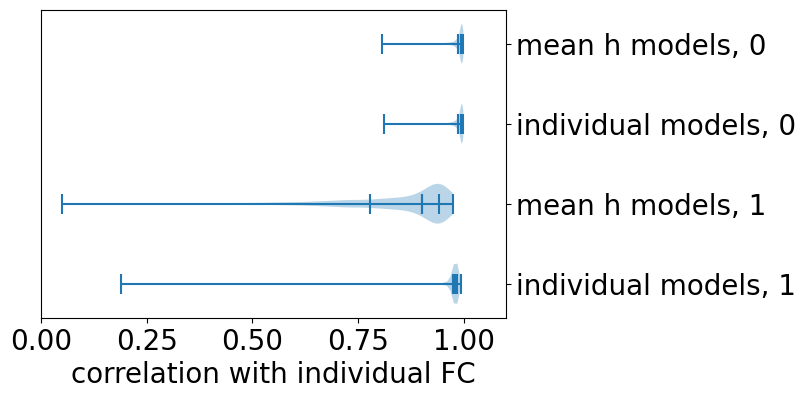

In [72]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
# 'group model v. individual data, threshold=0', 
# 'group model v. individual data, threshold=1', 
corr_labels = ['individual models, 1', 'mean h models, 1', 'individual models, 0', 'mean h models, 0']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fc.flatten() ) for fc in [fc_corr_individual_1, fc_corr_individual_1_group_mean_h, fc_corr_individual_0, fc_corr_individual_0_group_mean_h] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('correlation with individual FC')
axs.set_xlim([0.0, 1.1])
# axs.set_title('effect of replacing h with group mean')
plt.show()

In [73]:
result_0 = stats.wilcoxon(  x=depytorch( fc_corr_individual_0.flatten() ), y=depytorch( fc_corr_individual_0_group_mean_h.flatten() ), alternative='greater'  )
print(f'FC corr. individual h > group mean h, threshold=0 p-value = {result_0.pvalue:.3g}, stat {result_0.statistic:.3g}')
result_1 = stats.wilcoxon(  x=depytorch( fc_corr_individual_1.flatten() ), y=depytorch( fc_corr_individual_1_group_mean_h.flatten() ), alternative='greater'  )
print(f'FC corr. individual h > group mean h, threshold=1 p-value = {result_1.pvalue:.3g}, stat {result_1.statistic:.3g}')

FC corr. individual h > group mean h, threshold=0 p-value = 7.08e-05, stat 4.68e+06
FC corr. individual h > group mean h, threshold=1 p-value = 0, stat 8.74e+06


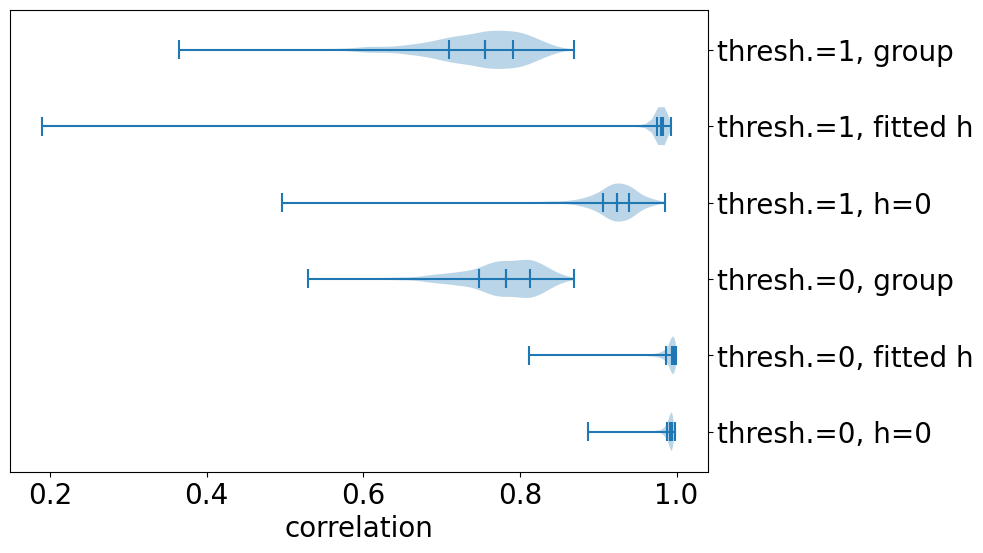

In [74]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
# 'group model v. individual data, threshold=0', 
# 'group model v. individual data, threshold=1', 
corr_labels = ['thresh.=0, h=0', 'thresh.=0, fitted h', 'thresh.=0, group', 'thresh.=1, h=0', 'thresh.=1, fitted h', 'thresh.=1, group']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fc.flatten() ) for fc in [fc_corr_individual_0_no_h, fc_corr_individual_0, fc_corr_group_vs_individual_0, fc_corr_individual_1_no_h, fc_corr_individual_1, fc_corr_group_vs_individual_1] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('correlation')
plt.show()

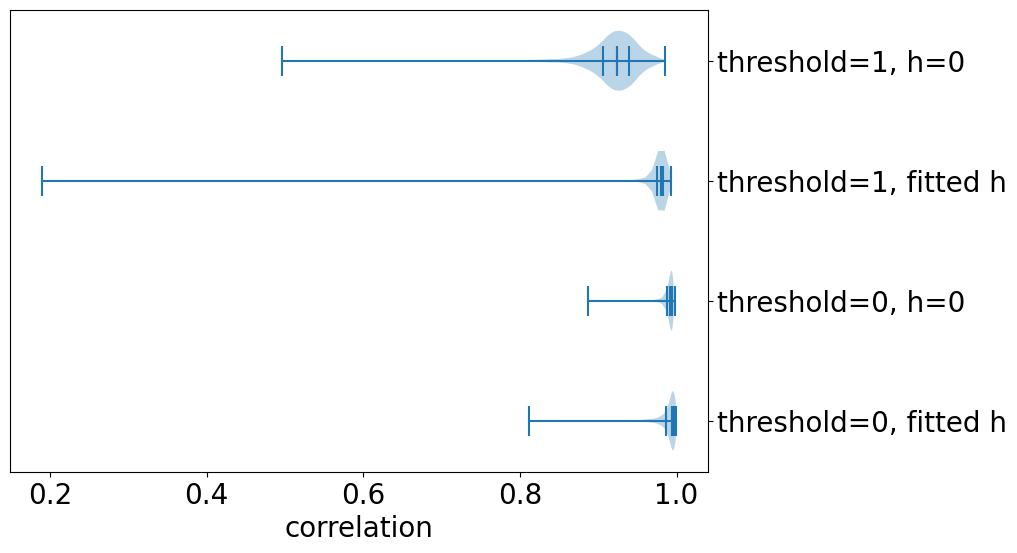

In [75]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
# 'group model v. individual data, threshold=0', 
# 'group model v. individual data, threshold=1', 
corr_labels = ['threshold=0, fitted h', 'threshold=0, h=0', 'threshold=1, fitted h', 'threshold=1, h=0']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fc.flatten() ) for fc in [fc_corr_individual_0, fc_corr_individual_0_no_h, fc_corr_individual_1, fc_corr_individual_1_no_h] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('correlation')
plt.show()

NameError: name 'fc_corr_individual_vs_individual' is not defined

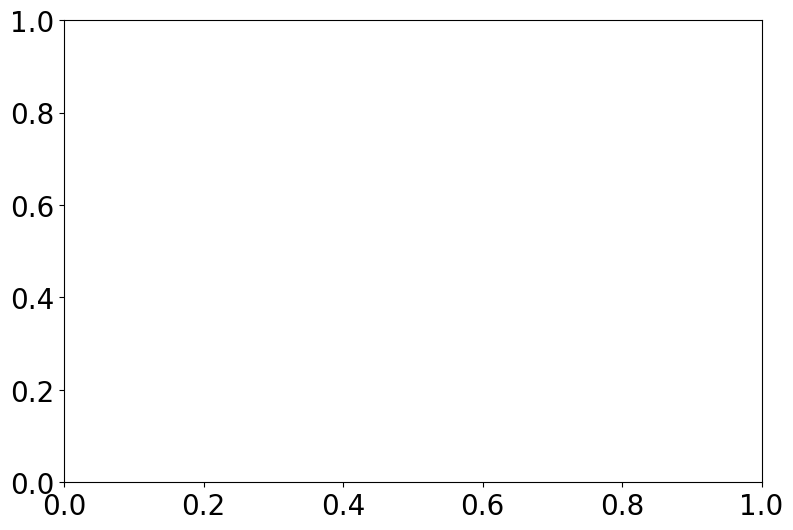

In [56]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
individiual_vs_individual_np = depytorch( fc_corr_individual_vs_individual.flatten() )
group_vs_individual_np = depytorch( fc_corr_group_vs_individual.flatten() )
axs.hist( individiual_vs_individual_np, label='individual model vs individual data' )
axs.hist( group_vs_individual_np, label='group model vs individual data' )
axs.legend()
axs.set_xlabel('FC correlation')
axs.set_ylabel('count')
plt.show()
# print( stats.wilcoxon(individiual_vs_individual_np, group_vs_individual_np, alternative='two-sided') )

In [106]:
fc_corr_from_guess_file = os.path.join(file_dir, 'summary_fc_corr_other_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_updates_min_0_max_20000_increment_1000.pt')
fc_corr_from_guess = torch.load(fc_corr_from_guess_file, weights_only=False)
print( fc_corr_from_guess.size() )

torch.Size([21, 5])


In [107]:
fc_corr_from_group_file = os.path.join(file_dir, 'summary_fc_corr_other_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_updates_min_0_max_10000_increment_1000.pt')
fc_corr_from_group = torch.load(fc_corr_from_group_file, weights_only=False)
print( fc_corr_from_group.size() )

torch.Size([11, 5])


In [97]:
fc_corr_from_guess_file = os.path.join(file_dir, 'summary_fc_corr_other_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_updates_min_0_max_40000_increment_1000.pt')
fc_corr_from_guess = torch.load(fc_corr_from_guess_file, weights_only=False)
print( fc_corr_from_guess.size() )

torch.Size([41, 5])


In [98]:
fc_corr_from_group_file = os.path.join(file_dir, 'summary_fc_corr_other_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_30000_individual_updates_updates_min_0_max_10000_increment_1000.pt')
# fc_corr_from_group_file = os.path.join(file_dir, 'summary_fc_corr_other_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_updates_min_0_max_30000_increment_1000.pt')
fc_corr_from_group = torch.load(fc_corr_from_group_file, weights_only=False)
print( fc_corr_from_group.size() )

torch.Size([11, 5])


In [108]:
num_param_updates = min( fc_corr_from_guess.size(dim=0), fc_corr_from_group.size(dim=0) )
fc_corr_from_guess = fc_corr_from_guess[:num_param_updates,:]
fc_corr_from_group = fc_corr_from_group[:num_param_updates,:]
param_update_count = torch.arange(0, 1000*num_param_updates, 1000, dtype=fc_corr_from_guess.dtype, device=fc_corr_from_guess.device)
print( param_update_count.numel() )

11


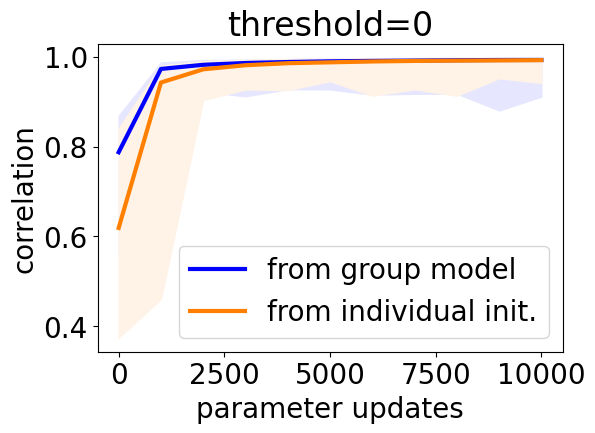

In [109]:
line_width = 3.0
update_count_np = depytorch(param_update_count)
fc_corr_from_guess_min = depytorch(fc_corr_from_guess[:,min_col])
fc_corr_from_guess_median = depytorch(fc_corr_from_guess[:,median_col])
fc_corr_from_guess_max = depytorch(fc_corr_from_guess[:,max_col])
fc_corr_from_group_min = depytorch(fc_corr_from_group[:,min_col])
fc_corr_from_group_median = depytorch(fc_corr_from_group[:,median_col])
fc_corr_from_group_max = depytorch(fc_corr_from_group[:,max_col])
from_guess_cval = orange_cval
from_group_cval = blue_cval

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )

axs.fill_between( update_count_np, fc_corr_from_group_min, fc_corr_from_group_max, color=[0.9+0.1*c for c in from_group_cval])# , label=f'range, starting from group model'
# axs.plot( update_count_np, fc_corr_from_group_min, color=from_group_cval, linestyle='--', linewidth=line_width )
# axs.plot( update_count_np, fc_corr_from_group_max, color=from_group_cval, linestyle='--', linewidth=line_width )
axs.plot( update_count_np, fc_corr_from_group_median, color=from_group_cval, linewidth=line_width, label=f'from group model' )

axs.fill_between( update_count_np, fc_corr_from_guess_min, fc_corr_from_guess_max, color=[0.9+0.1*c for c in from_guess_cval])# , label=f'range, starting from individual data-derived guess'
# axs.plot( update_count_np, fc_corr_from_guess_min, color=from_guess_cval, linestyle='--', linewidth=line_width )
# axs.plot( update_count_np, fc_corr_from_guess_max, color=from_guess_cval, linestyle='--', linewidth=line_width )
axs.plot( update_count_np, fc_corr_from_guess_median, color=from_guess_cval, linewidth=line_width, label=f'from individual init.' )#  label=f'median, starting from individual data-derived guess'

axs.legend( loc='lower right' )
axs.set_xlabel('parameter updates')
axs.set_ylabel('correlation')
axs.set_title('threshold=0')
plt.show()

In [38]:
num_beta = 11
beta_min = 1e-10
beta_max = 1.0
threshold = 1.0
fc_corr_pl_indi = torch.load( os.path.join(file_dir, f'fc_corr_pseudolikelihood_individual_threshold_{threshold:.3g}_lr_0.01_updates_20000_betas_{num_beta}_min_{beta_min:.3g}_max_{beta_max:.3g}_sim_length_120000.pt'), weights_only=False )
print( fc_corr_pl_indi.size() )
betas = torch.linspace(start=beta_min, end=beta_max, steps=num_beta, dtype=fc_corr_pl_indi.dtype, device=fc_corr_pl_indi.device)

torch.Size([11, 837])


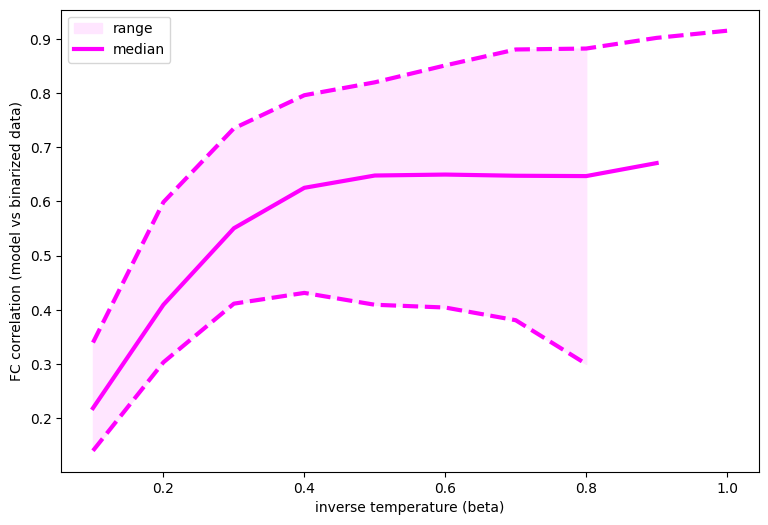

In [39]:
fc_corr_is_nan = torch.isnan(fc_corr_pl_indi)
fc_corr_is_inf = torch.isinf(fc_corr_pl_indi)
fc_corr_is_bad = torch.logical_or(fc_corr_is_nan, fc_corr_is_inf)
fc_corr_pl_indi[fc_corr_is_bad] = -float('inf')

fc_corr_pl_indi_min = torch.min(fc_corr_pl_indi, dim=-1).values
fc_corr_pl_indi_median = torch.median(fc_corr_pl_indi, dim=-1).values
fc_corr_pl_indi_max = torch.max(fc_corr_pl_indi, dim=-1).values

betas_np = depytorch(betas)
fc_corr_pl_indi_min_np = depytorch(fc_corr_pl_indi_min)
fc_corr_pl_indi_median_np = depytorch(fc_corr_pl_indi_median)
fc_corr_pl_indi_max_np = depytorch(fc_corr_pl_indi_max)
pseudolikelihood_cval = [1.0, 0.0, 1.0]

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )

axs.fill_between( betas_np, fc_corr_pl_indi_min_np, fc_corr_pl_indi_max_np, color=[0.9+0.1*c for c in pseudolikelihood_cval], label=f'range')
axs.plot( betas_np, fc_corr_pl_indi_min_np, color=pseudolikelihood_cval, linestyle='--', linewidth=line_width )
axs.plot( betas_np, fc_corr_pl_indi_max_np, color=pseudolikelihood_cval, linestyle='--', linewidth=line_width )
axs.plot( betas_np, fc_corr_pl_indi_median_np, color=pseudolikelihood_cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('inverse temperature (beta)')
axs.set_ylabel('FC correlation (model vs binarized data)')
plt.show()

In [40]:
print(fc_corr_pl_indi_min)
print(fc_corr_pl_indi_median)
print(fc_corr_pl_indi_max)

tensor([  -inf, 0.1401, 0.3032, 0.4113, 0.4312, 0.4093, 0.4042, 0.3808, 0.3001,
          -inf,   -inf], device='cuda:0')
tensor([  -inf, 0.2187, 0.4094, 0.5504, 0.6251, 0.6477, 0.6495, 0.6473, 0.6467,
        0.6707,   -inf], device='cuda:0')
tensor([  -inf, 0.3396, 0.5987, 0.7347, 0.7959, 0.8196, 0.8508, 0.8802, 0.8819,
        0.9016, 0.9148], device='cuda:0')


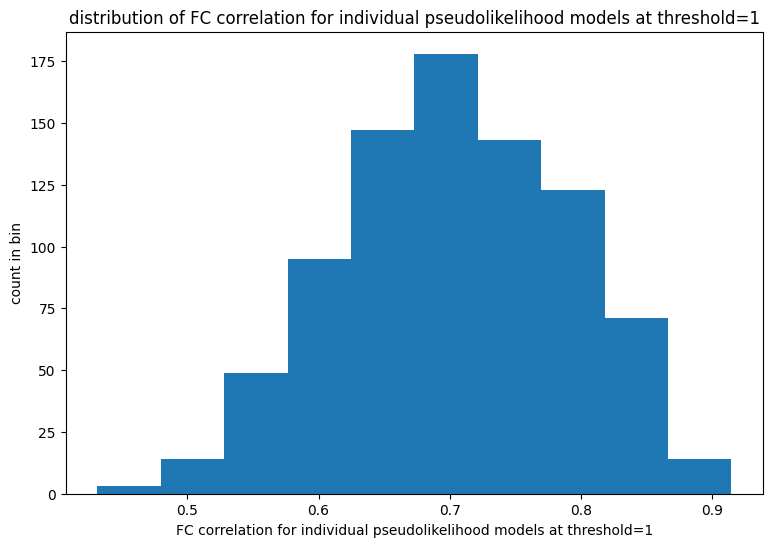

The distribution of FC correlation for individual pseudolikelihood models at threshold=1 values has median 0.705 with 95% CI [0.536, 0.855] and range [0.431, 0.915].


In [42]:
fc_corr_pl_indi_best_for_subject = torch.max(fc_corr_pl_indi, dim=0).values
name=f'FC correlation for individual pseudolikelihood models at threshold={threshold:.3g}'
values=fc_corr_pl_indi_best_for_subject
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [13]:
fc_corr_short = torch.load( os.path.join(file_dir, 'fc_corr_test_length_120000_ising_model_aal_short_threshold_1_beta_updates_9.pt'), weights_only=False )
print( fc_corr_short.size() )

torch.Size([101, 446])


In [17]:
is_not_nan = torch.logical_not( torch.isnan(fc_corr_short) )
print( torch.count_nonzero(is_not_nan).item(), 'of', is_not_nan.numel(), 'FC correlations are not NaN.' )
non_nan_fc_corrs = fc_corr_short[is_not_nan]
print(f'min {non_nan_fc_corrs.min():.3g}, mean {non_nan_fc_corrs.mean():.3g}, max {non_nan_fc_corrs.max():.3g}')

44743 of 45046 FC correlations are not NaN.
min 0.0574, mean 0.157, max 0.461


In [25]:
fc_corr_zero = torch.load( os.path.join(file_dir, 'flip_rate_zero_test_beta_min_1e-09_max_1_sim_steps_120000.pt'), weights_only=True )
print( fc_corr_zero.size() )
print( fc_corr_zero.min().item(), fc_corr_zero.mean().item(), fc_corr_zero.max().item() )

torch.Size([101, 1, 360])
1.0 1.0 1.0


In [26]:
test_beta = torch.linspace( start=1e-09, end=1.0, steps=fc_corr_zero.size(dim=0), dtype=fc_corr_zero.dtype, device=fc_corr_zero.device)

In [27]:
torch.count_nonzero( torch.isnan(fc_corr_zero) )

tensor(0, device='cuda:0')

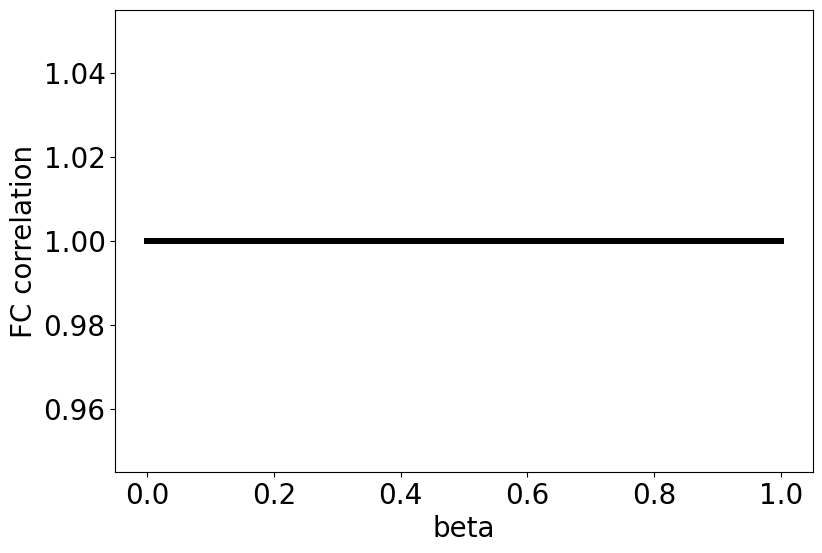

In [28]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
test_beta_np = depytorch(test_beta)
fc_corr_beta_test_np = depytorch(fc_corr_zero)
line_width = 3.0
max_beta_index = test_beta.numel()
# max_beta_index = torch.argmin( torch.abs(test_beta - 0.02) )
threshold_index = 0
cval = [0.0, 0.0, 0.0]
axs.plot( test_beta_np[:max_beta_index], fc_corr_beta_test_np[:max_beta_index,threshold_index], color=cval, linewidth=line_width )
axs.set_xlabel('beta')
axs.set_ylabel('FC correlation')
plt.show()